[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.axes_style("whitegrid")

import scipy.integrate as integrate

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, binarize, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score  
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_validate

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Const And Global Vars

In [2]:
CORES = 3
CV_SPLIT = 10
model_dict = {}
CLASS_NAMES = {0: 'shirt', 1: 'trousers', 2: 'pullover', 3: 'dress', 4: 'coat', 5: 'sandals', 6: 'shirt', 7: 'sneaker', 8: 'bag', 9: 'ankle boots'}

# Declare funcs

In [3]:
def paint():
    tmp = train_df.groupby('label').sum()
    train_data = np.array(tmp, dtype='float32')

    first_image = train_data[0]

    first_image = np.array(first_image, dtype='uint8')
    pixels = first_image.reshape((28, 28))
    import numpy as np; np.random.seed(0)

    import seaborn as sns; sns.set()

    # uniform_data = np.random.rand(10, 12)
    uniform_data = pixels#//500
    ax = sns.heatmap(uniform_data)

    uniform_data.max()

In [4]:
def evaluate(true, pred, plot=False):
#     model_accuracy = roc_auc_score(true, pred, multi_class="ovr")
#     null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
#     print("Null AUC Score: {:.5f}".format(null_accuracy))
#     print("Model AUC Score: {:.5f}".format(model_accuracy))

#     if null_accuracy >= model_accuracy:
#         print("The model isn't effective")
# #         return
#     else:
#         print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))
    print('f1 score {}'.format(f1_score(true, pred, average='weighted')))
    print('accuracy score {}'.format(accuracy_score(true, pred)))
    if plot:
        plot_scores(true, pred)

In [5]:
def plot_scores(true, pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    labels = np.unique(true)

    ytest = label_binarize(true, classes=labels)
    ypreds = label_binarize(pred, classes=labels)

    n_classes = len(labels)
    f1_scores = dict()
    accuracy_scores = dict()
    for i in range(n_classes):
        f1_scores[i] = f1_score(ytest[:, i], ypreds[:, i], average='weighted')
        accuracy_scores[i] = accuracy_score(ytest[:, i], ypreds[:, i])
        plt.scatter(f1_scores[i], accuracy_scores[i], lw=2, label=CLASS_NAMES[i])

    x = list(f1_scores.values())
    y = list(accuracy_scores.values())
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")
    print("y=%.6fx+(%.6f)"%(z[0],z[1]))
#     integrate_score = (integrate.quad(lambda x: x-(z[0]*x+z[1]), 0, 1)[0])
#     print('integrate score is {}'.format(integrate_score))
    
    plt.xlabel("f1_scores")
    plt.ylabel("accuracy_scores")
    plt.legend(loc="best")
    plt.title("f1_scores vs. accuracy_scores")
    plt.show()
    print(labels)
    print(accuracy_scores)
    print(f1_scores)
    return f1_scores

In [6]:
def score_models(model, model_scores):
    model_dict.update({model: model_scores})

    print("Accuracy: {:.2f} (+/- {:.2f})".format(model_scores['test_score'].mean(), model_scores['test_score'].std() * 2))
    print('Train time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['fit_time'].mean(), model_scores['fit_time'].std() * 2, model_scores['fit_time'].sum()))
    print('Test time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['score_time'].mean(), model_scores['score_time'].std() * 2, model_scores['score_time'].sum()))

In [7]:
def find_best_model():
    max_score = 0
    best_key = None
    for key in model_dict:
        model_score=model_dict[key]['test_score'].mean()
#         model_score = model_dict[key].mean()
#         try:   
#             model_score=model_dict[key]['test_score'].mean()
#         except IndexError: # remove this
#             model_score=model_dict[key].mean()
        if max_score < model_score:
            max_score = model_score
            best_key = key
    best_model_name = best_key
    print('the best model is {}'.format(best_key).split('(')[0], end = ' ')
    print('with the score of {}'.format(max_score))
    return best_key, max_score

In [8]:
def cv_mean_model(model_estimators, true, X_pred):
    size = len(true)
    split = size//CV_SPLIT
    X_cv_split = np.arange(0, size+1, split)

    pred_2d = np.zeros((CV_SPLIT, size))
    for idx, estimator in enumerate(model_estimators):
        pred = estimator.predict(X_pred)
        pred_2d[idx] = pred
        
    predictions = pred_2d[0].copy()
    tmp = np.rot90(pred_2d) 
    
    for idx in range(size):
        u, indices = np.unique(tmp[idx], return_index=True)
        predictions[idx] = u[0]
    evaluate(true, np.flip(predictions), plot=True)

---
# Data preparation

## load data

In [9]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

In [10]:
train_df.head()
train_df.isnull().sum().unique()

array([0], dtype=int64)

0 is t shirt\
1 is trousers\
2 is pullover\
3 is dress\
4 is coat\
5 is sandals\
6 is shirt\
7 is sneaker\
8 is bag\
9 is ankle boots

In [11]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [12]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


## split the training data into train and validate

In [13]:
# train_data = np.array(train_df, dtype='float32')
# test_data = np.array(test_df, dtype='float32')

X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

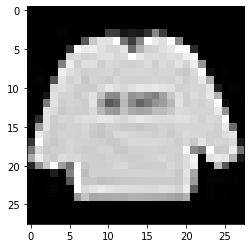

In [14]:
first_image = X_train.iloc[0]

first_image = np.array(first_image, dtype='uint8')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

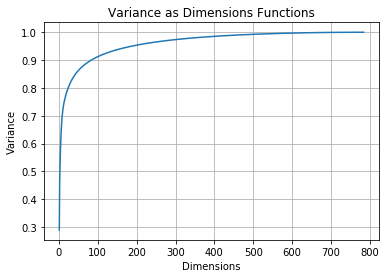

In [15]:
pca = PCA(random_state=0)
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.grid(True)
plt.title('Variance as Dimensions Functions')
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.show()

In [16]:
pca = PCA(random_state=0, n_components=0.90)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
d = len(pca.singular_values_)
print('the number of vectors after pca is {}'.format(d))

the number of vectors after pca is 84


---
# Models

## Run The Models

### Naive Bayes

Accuracy: 0.77 (+/- 0.01)
Train time: 0.16 seconds (+/- 0.04) for a total of 1.64 seconds
Test time: 0.09 seconds (+/- 0.02) for a total of 0.90 seconds
confusion_matrix:
 [[4630    1  129  394   21   34  387    0  402    2]
 [  40 5469  105  239   11    9   63    0   64    0]
 [ 126    0 3904   40  743   43  825    0  319    0]
 [ 419   43   69 4836  190   27  284    0  132    0]
 [  43    3  678  309 3956   13  826    1  171    0]
 [  16    0    1    2    1 4706  117  864  202   91]
 [1068    2  730  215  478   30 2996    0  481    0]
 [   4    0    0    0    0  332   17 5262   14  371]
 [  67    0   45   51   55  134  217  164 5260    7]
 [   4    0    0    0    0  115   33  422   76 5350]]
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      6000
           1       0.99      0.91      0.95      6000
           2       0.69      0.65      0.67      6000
           3       0.79      0.81      0.80      6000
           4       0.73   

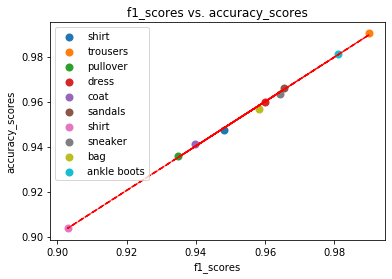

[0 1 2 3 4 5 6 7 8 9]
{0: 0.9473833333333334, 1: 0.9903333333333333, 2: 0.9357833333333333, 3: 0.9597666666666667, 4: 0.94095, 5: 0.96615, 6: 0.9037833333333334, 7: 0.9635166666666667, 8: 0.95665, 9: 0.9813166666666666}
{0: 0.9481648727287624, 1: 0.9901525453538266, 2: 0.9349503726538761, 3: 0.959893778655714, 4: 0.9396935188050166, 5: 0.9654129991578263, 6: 0.9029268462865043, 7: 0.9644185090769607, 8: 0.9582744776333755, 9: 0.9811906674065498}


In [17]:
gnb = GaussianNB()
gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True)
score_models(gnb, gnb_scores)
cv_mean_model(gnb_scores['estimator'], y_train, X_train_pca)

### SVM

#### Liniar SVC

In [18]:
# lsvc = LinearSVC(random_state=0)
# lsvc_scores = cross_validate(lsvc, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
# score_models(lsvc, lsvc_scores)
# cv_mean_model(lsvc_scores['estimator'], y_train, X_train_pca)

#### SVC

Accuracy: 0.79 (+/- 0.02)
Train time: 82.82 seconds (+/- 24.21) for a total of 828.22 seconds
Test time: 12.27 seconds (+/- 4.06) for a total of 122.74 seconds
confusion_matrix:
 [[5349    4   53  153    5    3  409    0   23    1]
 [  39 5847    7  101    3    0    1    0    2    0]
 [ 448    5 5136   37  179    1  187    0    7    0]
 [ 264   48  307 5303   13    0   55    0   10    0]
 [  49   15 3129  547 1854    0  397    0    9    0]
 [   3    1    0    2    0 5707    0  246   13   28]
 [1585    9 1084  166  840    1 2279    0   36    0]
 [   0    0    0    0    0   98    0 5762    5  135]
 [  34    1   48   27   11   11   20   17 5831    0]
 [   2    0    1    1    0  102    0  190    3 5701]]
              precision    recall  f1-score   support

           0       0.69      0.89      0.78      6000
           1       0.99      0.97      0.98      6000
           2       0.53      0.86      0.65      6000
           3       0.84      0.88      0.86      6000
           4       

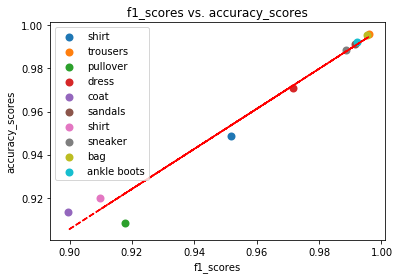

[0 1 2 3 4 5 6 7 8 9]
{0: 0.94875, 1: 0.9960666666666667, 2: 0.90845, 3: 0.97115, 4: 0.9133833333333333, 5: 0.9915166666666667, 6: 0.9201666666666667, 7: 0.9884833333333334, 8: 0.9953833333333333, 9: 0.9922833333333333}
{0: 0.9516210109650048, 1: 0.9960564009961878, 2: 0.9177285863746456, 3: 0.9714988839981848, 4: 0.8995377235931662, 5: 0.9914922955296103, 6: 0.9097991102057836, 7: 0.9885732013277976, 8: 0.9953728423977064, 9: 0.9922442501024584}


In [19]:
svc = SVC(random_state=0, max_iter=500)
svc_scores = cross_validate(svc, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
score_models(svc, svc_scores)
cv_mean_model(svc_scores['estimator'], y_train, X_train_pca)

### Logistic Regression

Accuracy: 0.84 (+/- 0.01)
Train time: 13.45 seconds (+/- 4.12) for a total of 134.54 seconds
Test time: 0.00 seconds (+/- 0.00) for a total of 0.05 seconds
confusion_matrix:
 [[5099   21   99  268   37   15  405    7   46    3]
 [  26 5781   25  130   13    0   21    2    2    0]
 [ 109   29 4507   63  741   15  492    5   39    0]
 [ 253   86   78 5206  191    2  159    3   18    4]
 [  15   15  603  259 4562    5  515    1   25    0]
 [   6    1    1    3    1 5625    2  261   26   74]
 [ 992   19  728  203  666    9 3279    5   96    3]
 [   0    0    0    0    0  262    1 5524   13  200]
 [  40    8   47   60   25   59  125   43 5582   11]
 [   0    1    0    2    0  115    1  238    4 5639]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      6000
           1       0.97      0.96      0.97      6000
           2       0.74      0.75      0.75      6000
           3       0.84      0.87      0.85      6000
           4       0.73

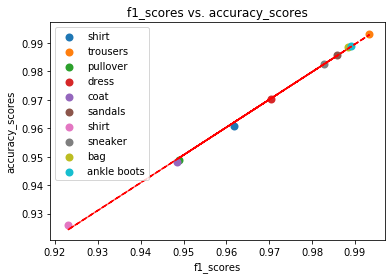

[0 1 2 3 4 5 6 7 8 9]
{0: 0.9609666666666666, 1: 0.99335, 2: 0.9487666666666666, 3: 0.9703, 4: 0.9481333333333334, 5: 0.9857166666666667, 6: 0.9259666666666667, 7: 0.98265, 8: 0.98855, 9: 0.9890666666666666}
{0: 0.9617090235868336, 1: 0.9933403587761912, 2: 0.9489322647828494, 3: 0.970509532533079, 4: 0.948576725339508, 5: 0.9857727011768266, 6: 0.9229411175979984, 7: 0.9827067111725316, 8: 0.988485908339927, 9: 0.9890397724192104}


In [20]:
lr = LogisticRegression(random_state=0, n_jobs=CORES)#, solver='lbfgs', penalty='l2')
lr_scores = cross_validate(lr, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
score_models(lr, lr_scores)
cv_mean_model(lr_scores['estimator'], y_train, X_train_pca)

### Decision Tree

Accuracy: 0.77 (+/- 0.01)
Train time: 12.32 seconds (+/- 0.55) for a total of 123.23 seconds
Test time: 0.00 seconds (+/- 0.00) for a total of 0.05 seconds
confusion_matrix:
 [[6000    0    0    0    0    0    0    0    0    0]
 [  69 5931    0    0    0    0    0    0    0    0]
 [ 139   27 5834    0    0    0    0    0    0    0]
 [ 346  181  107 5366    0    0    0    0    0    0]
 [  86   33  857  312 4712    0    0    0    0    0]
 [  18    2   17    8   13 5942    0    0    0    0]
 [ 921   50  813  273  752   13 3178    0    0    0]
 [   1    1    3    1    3  474    2 5515    0    0]
 [  77   13  123   74   99  112  179   39 5284    0]
 [   4    2    1    2    0  218    5  402   24 5342]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      6000
           1       0.95      0.99      0.97      6000
           2       0.75      0.97      0.85      6000
           3       0.89      0.89      0.89      6000
           4       0.84

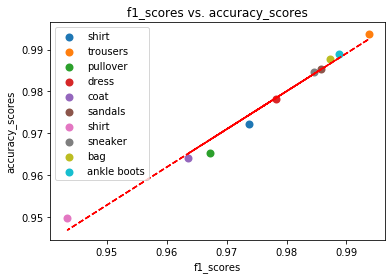

[0 1 2 3 4 5 6 7 8 9]
{0: 0.9723166666666667, 1: 0.9937, 2: 0.9652166666666666, 3: 0.9782666666666666, 4: 0.9640833333333333, 5: 0.9854166666666667, 6: 0.9498666666666666, 7: 0.9845666666666667, 8: 0.9876666666666667, 9: 0.9890333333333333}
{0: 0.9737834285271526, 1: 0.993754749115682, 2: 0.9671483859167304, 3: 0.9782955457291568, 4: 0.9635001200435628, 5: 0.9857988222141132, 6: 0.9434075443632427, 7: 0.9845414106409865, 8: 0.9873285545011927, 9: 0.9887484261225924}


In [21]:
dtc = DecisionTreeClassifier(random_state=0)
dtc_scores = cross_validate(dtc, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
score_models(dtc, dtc_scores)
cv_mean_model(dtc_scores['estimator'], y_train, X_train_pca)

### Gradient Boosting

In [22]:
# gb = GradientBoostingClassifier(random_state=0, n_estimators=10)
# gb_scores = cross_validate(gb, X_train_pca, y_train, cv=CV_SPLIT//2, return_estimator=True, n_jobs=CORES)
# score_models(gb, gb_scores)
# cv_mean_model(gb_scores['estimator'], y_train, X_train_pca)

### Random Forest

Accuracy: 0.87 (+/- 0.01)
Train time: 27.31 seconds (+/- 3.62) for a total of 273.13 seconds
Test time: 0.14 seconds (+/- 0.09) for a total of 1.38 seconds
confusion_matrix:
 [[5996    0    0    4    0    0    0    0    0    0]
 [  15 5977    0    8    0    0    0    0    0    0]
 [  56    1 5936    1    5    0    1    0    0    0]
 [ 165   21   38 5775    1    0    0    0    0    0]
 [   8    4  496  229 5260    0    3    0    0    0]
 [   1    0    0    4    0 5979    0   16    0    0]
 [ 984    6  676  143  563   13 3615    0    0    0]
 [   0    0    0    0    0  195    0 5794    0   11]
 [   8    0   27   39   25   66   61   23 5751    0]
 [   0    0    1    1    0  114    0  195    4 5685]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      6000
           1       0.99      1.00      1.00      6000
           2       0.83      0.99      0.90      6000
           3       0.93      0.96      0.95      6000
           4       0.90

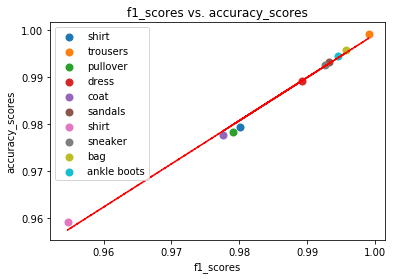

[0 1 2 3 4 5 6 7 8 9]
{0: 0.9793166666666666, 1: 0.9990833333333333, 2: 0.9783, 3: 0.9891, 4: 0.9777666666666667, 5: 0.9931833333333333, 6: 0.9591666666666666, 7: 0.9926666666666667, 8: 0.9957833333333334, 9: 0.9945666666666667}
{0: 0.9801608324932904, 1: 0.9990836386280866, 2: 0.9791476572199713, 3: 0.9891807873519644, 4: 0.9776447558437668, 5: 0.9932728566679525, 6: 0.954702772999958, 7: 0.9926742514419269, 8: 0.9957441630071863, 9: 0.9945036810809075}


In [23]:
rf = RandomForestClassifier(max_depth=20, random_state=0, n_jobs=CORES)
rf_scores = cross_validate(rf, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES, return_estimator=True)
score_models(rf, rf_scores)
cv_mean_model(rf_scores['estimator'], y_train, X_train_pca)

### KNN

#### find the optimum K 

In [24]:
k_max = 15
k_min = 1
err_rate = []
for i in range(k_min, k_max+1):
    k = KNeighborsClassifier(n_neighbors=i, n_jobs=CORES)
#     k.fit(X_train_pca, y_train)
#     pred_i = k.predict(X_test_pca)
#     err_rate.append(np.mean(pred_i != y_test))
    scores = cross_validate(k, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES, return_estimator=True)['test_score']
    if scores.std() > 0.5:
        err_rate.append(0)
    else:
        err_rate.append(scores.mean())

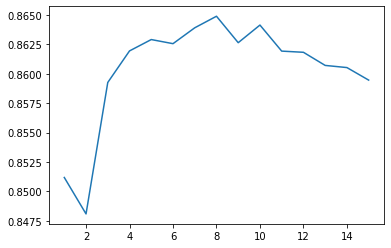

In [25]:
plt.plot(np.arange(k_min, k_max+1), err_rate)
plt.show()

In [26]:
index = err_rate.index(max(err_rate)) + 1
index

8

Accuracy: 0.86 (+/- 0.01)
Train time: 1.69 seconds (+/- 0.10) for a total of 16.89 seconds
Test time: 13.92 seconds (+/- 6.30) for a total of 139.24 seconds
confusion_matrix:
 [[5635    3   67   78   22    1  157    1   36    0]
 [  36 5847   16   77    7    0   14    0    2    1]
 [ 123    5 5268   41  359    1  192    1   10    0]
 [ 286   38   61 5455   98    0   52    0   10    0]
 [  38    8  746  254 4705    0  235    0   14    0]
 [   4    0    0    2    0 5621    1  193   11  168]
 [1317    9  842  107  481    0 3202    0   41    1]
 [   0    0    0    0    0   88    0 5771    1  140]
 [  33    2   60   35   32   12   41   28 5752    5]
 [   0    0    2    0    0   41    1  267    3 5686]]
              precision    recall  f1-score   support

           0       0.75      0.94      0.84      6000
           1       0.99      0.97      0.98      6000
           2       0.75      0.88      0.81      6000
           3       0.90      0.91      0.91      6000
           4       0.8

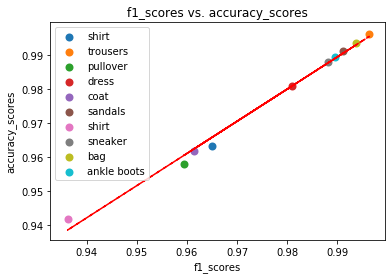

[0 1 2 3 4 5 6 7 8 9]
{0: 0.9633, 1: 0.9963666666666666, 2: 0.9579, 3: 0.9810166666666666, 4: 0.9617666666666667, 5: 0.9913, 6: 0.9418166666666666, 7: 0.9880166666666667, 8: 0.9937333333333334, 9: 0.9895166666666667}
{0: 0.9650514284959997, 1: 0.9963547250681845, 2: 0.9594024134273348, 3: 0.9810509583297591, 4: 0.9613354472496862, 5: 0.9912222185934726, 6: 0.9361840664794245, 7: 0.9881296963815668, 8: 0.9937051611191456, 9: 0.9895170549014247}


In [27]:
k = KNeighborsClassifier(n_neighbors=index, n_jobs=CORES)
k_scores = cross_validate(k, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES, return_estimator=True)
score_models(k, k_scores)
cv_mean_model(k_scores['estimator'], y_train, X_train_pca)

## Find Best Model

In [28]:
best_model, best_model_score = find_best_model()

the best model is RandomForestClassifier with the score of 0.8666166666666667


## Improve The Model

### Ada Boost

#### find best estimator

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor

max_estimators = 20
abr = AdaBoostRegressor(best_model, n_estimators=max_estimators, learning_rate=2, random_state=0)
abr.fit(X_train_pca, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in abr.staged_predict(X_test_pca)]
bst_n_estimators = np.argmin(errors)
min_error = np.min(errors)
max_error = np.max(errors)

TypeError: No loop matching the specified signature and casting was found for ufunc true_divide

In [ ]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], 'k--')
plt.plot([0, 120], [min_error, min_error], 'k--')
plt.plot(bst_n_estimators, min_error, 'ko')
plt.text(bst_n_estimators, min_error*1.2, 'Minimum', ha='center', fontsize=14)
plt.axis([0, max_estimators, min_error-.5, max_error+.5])
plt.xlabel("Number of trees")
plt.title('Validation error', fontsize=14)
plt.show()
bst_n_estimators

#### run the model

In [ ]:
adb = AdaBoostClassifier(best_model, n_estimators=bst_n_estimators, random_state=0)
adb_scores = cross_validate(adb, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
cv_mean_model(adb_scores['estimator'], y_train, X_train_pca)

#### check if the model was improved

In [ ]:
if adb_scores['test_score'].mean() > best_model_score:
    print('ada boost helped')
    best_model = adb

## Test The Model On The Test Data

In [ ]:
cv_mean_model(adb_scores['estimator'], y_test, X_test_pca)

In [ ]:
adb.fit(X_train_pca, y_train)
predictions = best_model.predict(X_test_pca)
evaluate(y_test, predictions, plot=True)

---
# Challenges

In [ ]:
rfc = RandomForestClassifier(n_estimators=200, max_features='sqrt', random_state=0, n_jobs=CORES)
rfc.fit(X_train, y_train)

data = rfc.feature_importances_
image = data.reshape(28, 28)
plt.imshow(image, cmap=plt.cm.hot, interpolation='nearest')
plt.axis('off')

cbar = plt.colorbar(ticks=[rfc.feature_importances_.min(), rfc.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()